In [24]:
import numpy    as np
from numpy.testing._private.utils import decorate_methods
import pandas   as pd
import seaborn  as sns
import matplotlib.pyplot as plt
import sklearn  as skl
import time

from sklearn.pipeline import Pipeline      # Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import set_config
set_config(display='diagram') # Useful for display the pipeline

from sklearn.tree          import DecisionTreeRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.ensemble      import ExtraTreesRegressor
from sklearn.ensemble      import AdaBoostRegressor
from sklearn.ensemble      import GradientBoostingRegressor
from xgboost               import XGBRegressor
from lightgbm              import LGBMRegressor
from catboost              import CatBoostRegressor

In [28]:
data = pd.read_csv(r'data\london_merged.csv')
data.head()
data['year'] = data['timestamp'].apply(lambda row: row[:4])
data['month'] = data['timestamp'].apply(lambda row: row.split('-')[2][:2] )
data['hour'] = data['timestamp'].apply(lambda row: row.split(':')[0][-2:] )
data.drop('timestamp', axis=1, inplace=True)
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,hour
0,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,04,00
1,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,04,01
2,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,04,02
3,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,04,03
4,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,04,04


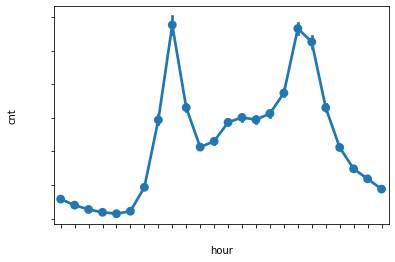

In [29]:
sns.pointplot(x='hour', y='cnt', data=data)
plt.xticks(color= 'white')
plt.yticks(color = 'white')
plt.show()


In [6]:
y = data['cnt']
x = data.drop(['cnt'], axis=1)


cat_vars = ['season','is_weekend','is_holiday','year','month','weather_code']
num_vars = ['t1','t2','hum','wind_speed']


x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2,random_state=0) # Recommended for reproducibility

transformer = PowerTransformer()
y_train = transformer.fit_transform(y_train.values.reshape(-1,1))
y_val = transformer.transform(y_val.values.reshape(-1,1))                     

In [7]:
num_4_treeModels = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-9999)),
])

cat_4_treeModels = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder()) # handle_unknown='ignore' ONLY IN VERSION 0.24
])

tree_prepro = ColumnTransformer(transformers=[
    ('num', num_4_treeModels, num_vars),
    ('cat', cat_4_treeModels, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

In [22]:
tree_classifiers = {
  "Decision Tree": DecisionTreeRegressor(),
  "Extra Trees":   ExtraTreesRegressor(n_estimators=100),
  "Random Forest": RandomForestRegressor(n_estimators=100),
  "AdaBoost":      AdaBoostRegressor(n_estimators=100),
  "Skl GBM":       GradientBoostingRegressor(n_estimators=100),
  "XGBoost":       XGBRegressor(n_estimators=100),
  "LightGBM":      LGBMRegressor(n_estimators=100),
  "CatBoost":      CatBoostRegressor(n_estimators=100),
}

tree_classifiers = {name: make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}

results = pd.DataFrame({'Model': [],'r_score':[], 'MSE': [], 'MAB': [], " % error": [], 'Time': []})

In [25]:
rang = abs(y_train.max()) + abs(y_train.min())
for model_name, model in tree_classifiers.items():
    
    start_time = time.time()
    model.fit(x_train, y_train)
    total_time = time.time() - start_time
        
    pred = model.predict(x_val)
    
    results = results.append({"Model":    model_name,
                              "r_score": r2_score(y_val, pred),
                              "MSE": mean_squared_error(y_val, pred),

                              "MAB": mean_absolute_error(y_val, pred),
                              " % error": mean_squared_error(y_val, pred) / rang,
                              "Time":     total_time},
                              ignore_index=True)

results_ord = results.sort_values(by=['MSE'], ascending=True, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['MSE', 'MAE'], vmin=0, vmax=100, color='#5fba7d')

print(results_ord)

C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\rnr31\anaconda3\envs\ds22\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d 

Learning rate set to 0.403579
0:	learn: 0.9032866	total: 42.2ms	remaining: 4.18s
1:	learn: 0.8588329	total: 46.9ms	remaining: 2.3s
2:	learn: 0.8323824	total: 53.6ms	remaining: 1.73s
3:	learn: 0.8154601	total: 60.5ms	remaining: 1.45s
4:	learn: 0.8067927	total: 65.8ms	remaining: 1.25s
5:	learn: 0.7988734	total: 72.9ms	remaining: 1.14s
6:	learn: 0.7943828	total: 79ms	remaining: 1.05s
7:	learn: 0.7921101	total: 84.4ms	remaining: 970ms
8:	learn: 0.7875037	total: 89.4ms	remaining: 904ms
9:	learn: 0.7852564	total: 95.2ms	remaining: 856ms
10:	learn: 0.7827256	total: 102ms	remaining: 824ms
11:	learn: 0.7804141	total: 108ms	remaining: 790ms
12:	learn: 0.7785373	total: 112ms	remaining: 749ms
13:	learn: 0.7773486	total: 118ms	remaining: 723ms
14:	learn: 0.7765437	total: 124ms	remaining: 701ms
15:	learn: 0.7753549	total: 143ms	remaining: 751ms
16:	learn: 0.7722506	total: 151ms	remaining: 736ms
17:	learn: 0.7712472	total: 156ms	remaining: 712ms
18:	learn: 0.7704070	total: 161ms	remaining: 687ms
19:	

In [26]:
results_ord

,Model,r_score,MSE,MAB,% error,Time
1,Random Forest,0.449461,0.547495,0.550727,0.099336,4.385271
2,Extra Trees,0.436973,0.559914,0.543111,0.101590,3.398903
3,LightGBM,0.419412,0.577378,0.584241,0.104758,0.512648
4,CatBoost,0.417889,0.578892,0.584143,0.105033,2.363399
5,XGBoost,0.408642,0.588088,0.583151,0.106701,1.071088
6,Skl GBM,0.374812,0.621731,0.612608,0.112806,1.243603
7,AdaBoost,0.306230,0.689934,0.660983,0.125180,0.558644
8,Decision Tree,-0.076914,1.070959,0.747288,0.194313,0.147605
